# Определение перспективного тарифа для телеком компании

Выбрать выгодный тарифный план для оптимизации рекламного бюджета.

### Оглавление
1. [Предобработка данных ](#1)
2. [Расчет помесячных значений для каждого пользователя](#2)
3. [Анализ поведения абонентов](#3)
4. [Проверка гипотез](#5)
5. [Общие выводы](#6)

## Предобработка данных <a class="anchor" id="1"></a>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
import math
df_users=pd.read_csv('/datasets/users.csv')
df_calls=pd.read_csv('/datasets/calls.csv')
df_messages=pd.read_csv('/datasets/messages.csv')
df_internet=pd.read_csv('/datasets/internet.csv')
df_tariffs=pd.read_csv('/datasets/tariffs.csv')

<b>По результатам предварительного анализа датафреймов методами info() и describe(), необходимо:</b>

1) отформатировать даты во всех датафремах, кроме тарифов, чтобы потом группировать данные помесячно

2) заменить 0 на NaN в длительности разговоров в df_calls и в трафике в df_internet (вероятно пропущенные звонки и исхолящий трафик)



### Обработка датафрейма users

In [13]:
# перевести даты в корректный формат, чтобы потом группировать помесячно
df_users['reg_date']=pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date']=pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Обработка датафрейма calls

In [14]:
# преобразование даты
df_calls['call_date']=pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [15]:
#посчитаем долю звонков длительностью 0
df_calls[df_calls['duration']==0]['duration'].count()/len(df_calls['duration'])

0.19551644316336553

Звонков с 0 длительностью много, заменим их на nan, чтобы они не влиялия на дальшейшие расчеты.
    

In [16]:
df_calls['duration'].replace(0, np.nan, inplace=True)
df_calls.describe()

,duration,user_id
count,162994.000000,202607.000000
mean,8.397794,1253.940619
std,5.353022,144.722751
min,0.010000,1000.000000
25%,4.170000,1126.000000
50%,7.740000,1260.000000
75%,11.850000,1379.000000
max,38.000000,1499.000000


### Обработка датафрейма messages


In [17]:
# преобразование даты
df_messages['message_date']=pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


### Обработка датафрейма messages

In [18]:
df_internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [19]:
# отформатируем дату и заменим 0 значения трафика на NaN (возможно это исходящий трафик?)
df_internet['session_date']=pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet['mb_used'].replace(0, np.nan, inplace=True)
df_internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         129798 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [20]:
df_internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,129798.000000,149396.000000
mean,74697.500000,426.087210,1252.099842
std,43127.054745,255.596447,144.050823
min,0.000000,0.030000,1000.000000
25%,37348.750000,227.460000,1130.000000
50%,74697.500000,400.540000,1251.000000
75%,112046.250000,592.947500,1380.000000
max,149395.000000,1724.830000,1499.000000


## Расчет помесячных значений для каждого пользователя <a class="anchor" id="2"></a>

<br>
Посчитаем для каждого пользователя:
<li>количество звонков и  минут  по месяцам;
<li>количество сообщений по месяцам;
<li>объем интернет-трафика по месяцам;
<li>помесячную выручку с каждого пользователя

Округляем длительность разговора в большую сторону, а нули заменим на единицы.


In [70]:
df_calls['duration_ceil']=df_calls['duration'].apply(np.ceil)
df_calls['duration_ceil']=df_calls['duration_ceil'].where(df_calls['duration_ceil']>0, 1)
df_calls.describe()

,duration,user_id,duration_ceil,month
count,162994.000000,202607.000000,202607.000000,202607.000000
mean,8.397794,1253.940619,7.353714,8.574067
std,5.353022,144.722751,5.733230,2.787093
min,0.010000,1000.000000,1.000000,1.000000
25%,4.170000,1126.000000,2.000000,7.000000
50%,7.740000,1260.000000,6.000000,9.000000
75%,11.850000,1379.000000,11.000000,11.000000
max,38.000000,1499.000000,38.000000,12.000000


In [40]:
#чтобы удобнее было проводить группировку по месяцам добавим в датафремы отдельный столбец с порядковым номером месяца
df_calls['month']=df_calls['call_date'].dt.month
df_messages['month']=df_messages['message_date'].dt.month
df_internet['month']=df_internet['session_date'].dt.month
#сгруппируем новый датафрем с помесячными данными для каждого пользователя по звонкам 
df_users_monthly=df_calls.groupby(['user_id','month']).agg({'duration_ceil':['sum', 'count']})
# добавим в него информацию по израсходованным сообещениям и интернет трафику из других датафреймов
df_users_monthly['messages']=df_messages.groupby(['user_id','month']).agg({'id': ['count']})
df_users_monthly['internet']=df_internet.groupby(['user_id','month']).agg({'mb_used': ['sum']})
df_users_monthly.columns =['call_duration_sum', 'call_count', 'messages', 'internet']
df_users_monthly

call_duration_sum  call_count  messages  internet
user_id month                                                   
1000    5                  164.0          22      22.0   2253.49
        6                  187.0          43      60.0  23233.77
        7                  346.0          47      75.0  14003.64
        8                  418.0          52      81.0  14055.93
        9                  478.0          58      57.0  14568.91
...                          ...         ...       ...       ...
1498    10                 258.0          41      42.0  20579.36
1499    9                   71.0           9      11.0   1845.75
        10                 473.0          68      48.0  17788.51
        11                 624.0          74      59.0  17963.31
        12                 505.0          69      66.0  13055.58

[3174 rows x 4 columns]

In [41]:
#добавим данные по тарифам для каждого пользователя
df_users_monthly=df_users_monthly.join(df_users.set_index('user_id'))


In [42]:
df_users_monthly.reset_index()

,user_id,month,call_duration_sum,call_count,messages,internet,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,164.0,22,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,187.0,43,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,346.0,47,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,418.0,52,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,478.0,58,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,10,258.0,41,42.0,20579.36,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
3170,1499,9,71.0,9,11.0,1845.75,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3171,1499,10,473.0,68,48.0,17788.51,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3172,1499,11,624.0,74,59.0,17963.31,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


In [43]:
#добавим данные по условиям тарифа
df_users_monthly=df_users_monthly.reset_index().merge(df_tariffs, left_on='tariff',right_on='tariff_name', how='left')

In [44]:
df_users_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 21 columns):
user_id                  3174 non-null int64
month                    3174 non-null int64
call_duration_sum        3174 non-null float64
call_count               3174 non-null int64
messages                 2678 non-null float64
internet                 3163 non-null float64
age                      3174 non-null int64
churn_date               187 non-null datetime64[ns]
city                     3174 non-null object
first_name               3174 non-null object
last_name                3174 non-null object
reg_date                 3174 non-null datetime64[ns]
tariff                   3174 non-null object
messages_included        3174 non-null int64
mb_per_month_included    3174 non-null int64
minutes_included         3174 non-null int64
rub_monthly_fee          3174 non-null int64
rub_per_gb               3174 non-null int64
rub_per_message          3174 non-null int64
rub_per_min

In [45]:
#вычислим помесячную выручку с каждого абонента

#функция для определения остатка минут, сообщений, трафика
import math
def diff(value, limit):
    if value > limit:
        return abs(limit-value)
    else:
        return 0
    
#функция расчета выручки    
def revenue_calc(row):
    #переводим лишние мегабайты в гигабайты и округляем в большую сторону до целого
    add_gb=diff(row['internet'], row['mb_per_month_included'])/1024
    revenue= (diff(row['messages'], row['messages_included'])*df_users_monthly['rub_per_message']
               + math.ceil(add_gb)*row['rub_per_gb']
               + diff(row['call_duration_sum'], row['minutes_included'])*row['rub_per_minute']
               + row['rub_monthly_fee'])
    return revenue

#расчет выручки
df_users_monthly['revenue'] = 0 #почему не работает без этого?
df_users_monthly['revenue'] = df_users_monthly.apply(revenue_calc, axis=1)

df_users_monthly                             

,user_id,month,call_duration_sum,call_count,messages,internet,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5,164.0,22,22.0,2253.49,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,6,187.0,43,60.0,23233.77,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,7,346.0,47,75.0,14003.64,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,8,418.0,52,81.0,14055.93,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,9,478.0,58,57.0,14568.91,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,10,258.0,41,42.0,20579.36,68,2018-10-25,Владикавказ,Всеволод,...,smart,50,15360,500,550,200,3,3,smart,1750.0
3170,1499,9,71.0,9,11.0,1845.75,35,NaT,Пермь,Гектор,...,smart,50,15360,500,550,200,3,3,smart,550.0
3171,1499,10,473.0,68,48.0,17788.51,35,NaT,Пермь,Гектор,...,smart,50,15360,500,550,200,3,3,smart,1150.0
3172,1499,11,624.0,74,59.0,17963.31,35,NaT,Пермь,Гектор,...,smart,50,15360,500,550,200,3,3,smart,1531.0


Попробуем удалить из выборки абонентов, которые уже отключились, чтобы они не искажали результат, т.к. их паттерны могут отличаться от текущих абонентов телеоператора (проверить, насколько меняются результаты, если их не выбрасывать) 


In [46]:
#удалить из выборки абонентов, которые уже отключились, чтобы они не искажали результат
#df_users_monthly=df_users_monthly.loc[df_users_monthly['churn_date'].isna()==True]

In [47]:
df_users_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 22 columns):
user_id                  3174 non-null int64
month                    3174 non-null int64
call_duration_sum        3174 non-null float64
call_count               3174 non-null int64
messages                 2678 non-null float64
internet                 3163 non-null float64
age                      3174 non-null int64
churn_date               187 non-null datetime64[ns]
city                     3174 non-null object
first_name               3174 non-null object
last_name                3174 non-null object
reg_date                 3174 non-null datetime64[ns]
tariff                   3174 non-null object
messages_included        3174 non-null int64
mb_per_month_included    3174 non-null int64
minutes_included         3174 non-null int64
rub_monthly_fee          3174 non-null int64
rub_per_gb               3174 non-null int64
rub_per_message          3174 non-null int64
rub_per_min

## Анализ поведения абонентов <a class="anchor" id="3"></a>

Чтобы оценить среднее количество минут, сообщений и трафика, которые тратят абоненты из выборки, пострим гистограммы и сравним по двум тарифам.

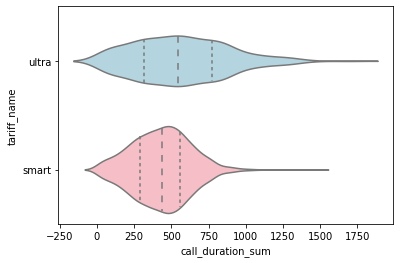

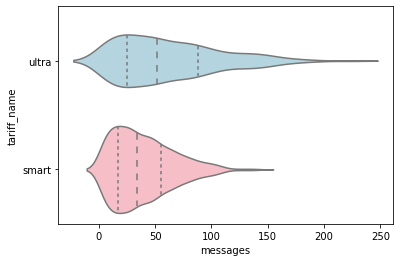

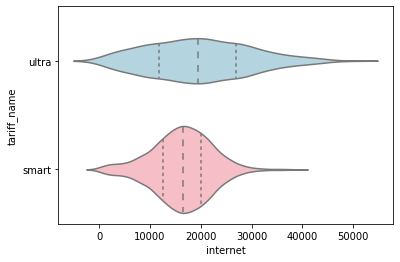

In [71]:
compare_list=["call_duration_sum", "messages", "internet"]
for i in range(len(compare_list)):
        sns.violinplot(compare_list[i], "tariff_name", data=df_users_monthly, 
               split=True, inner="quartile",
                palette=["lightblue", "lightpink"]);
        plt.show()  
#df_users_monthly[df_users_monthly['tariff_name']=='ultra'][['call_duration_sum', 'messages', 'internet']].hist(bins=50)
#df_users_monthly[df_users_monthly['tariff_name']=='smart'][['call_duration_sum', 'messages', 'internet']].hist(bins=50)


В целом абоненты тарифа Ультра, представленные в выборке, более активно пользуются связью, однако среди клиентов есть много тех, кто не успевает потратить все включенные в тариф минуты, сообщения и траффик. Есть вероятность, что со временем они решат оптимизировать свои расходы и откажутся от тарифа в пользу более дешевого. 

<li> Абоненты с тарифом Смарт используют в среднем 400 минут в месяц, отправляют меньше 50 сообщений и используют до 20 ГБ 
<li> Абоненты с тариформ Ультра - почти 500 минут, больше 50 сообщений и в 50% случаев превышают лимит в 20ГБ

### Вычисление среднего, отклонения и дисперсии. <a class="anchor" id="4"></a>

In [49]:
#Для тарифа Ультра
ultra_mean=np.mean(df_users_monthly[df_users_monthly['tariff_name']=='ultra'][['call_duration_sum', 'messages', 'internet']])
ultra_std = np.std(df_users_monthly[df_users_monthly['tariff_name']=='ultra'][['call_duration_sum', 'messages', 'internet']])
ultra_var= np.var(df_users_monthly[df_users_monthly['tariff_name']=='ultra'][['call_duration_sum', 'messages', 'internet']])
ultra = pd.concat([ultra_mean,ultra_std, ultra_var], axis=1).reset_index()
ultra.columns = ['metrics', 'mean', 'std', 'var']

#Для тарифа Смарт
smart_mean=np.mean(df_users_monthly[df_users_monthly['tariff_name']=='smart'][['call_duration_sum', 'messages', 'internet']])
smart_std = np.std(df_users_monthly[df_users_monthly['tariff_name']=='smart'][['call_duration_sum', 'messages', 'internet']])
smart_var= np.var(df_users_monthly[df_users_monthly['tariff_name']=='smart'][['call_duration_sum', 'messages', 'internet']])
smart = pd.concat([smart_mean,smart_std, smart_var], axis=1).reset_index()
smart.columns = ['metrics', 'mean', 'std', 'var']

#Объединяем для сравнения
ultra.merge(smart, on='metrics', suffixes=('_ultra', '_smart'))

,metrics,mean_ultra,std_ultra,var_ultra,mean_smart,std_smart,var_smart
0,call_duration_sum,560.113565,314.576647,9.895847e+04,430.609987,193.806767,3.756106e+04
1,messages,61.195538,44.687246,1.996950e+03,38.747390,26.810396,7.187974e+02
2,internet,19669.283603,9973.223529,9.946519e+07,16216.661274,5866.182614,3.441210e+07


Значения в выборке абонентов Ультра в выборке больше разбросаны, а средние выше. Вычисленные значения это подтверждают.

Если значения в генеральной совокупности разбросаны на расстоянии 3 сигма от среднего, то можно сказать, что большая часть абонентов тарифа Ультра не использует все купленные тарифом минуты и сообщения. С интеренетом ситуация лучше, похоже многие покупают тариф ради большого пакета интернета.

## Проверка гипотез <a class="anchor" id="5"></a>

Проверьте гипотезы
<li>средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
<li> средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
<p>    
<p><b>"Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"</b>
    
<b>H0: Средняя выручка пользователей тарифов «Ультра» и «Смарт» равна </b>

<b>H1: Средняя выручка пользователей тарифов «Ультра» не равна средней выручке пользователей тирифа «Смарт» </b>

Проведем Т-тест чтобы определить действительно ли средние генеральных совокупностей абонентов Смарт и Ультра отличаются.

In [72]:
# разделим выручку на две выборки по признаку тарифа
smart_rev = df_users_monthly[df_users_monthly['tariff_name']=='smart']['revenue']
ultra_rev = df_users_monthly[df_users_monthly['tariff_name']=='ultra']['revenue']

# проверим гипотезу о равенстве средних выручек двух совокупностей

alpha=0.05

results=st.ttest_ind(smart_rev, ultra_rev)
if(results.pvalue<alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть не получилось')
    
print(results.pvalue)


Отвергаем нулевую гипотезу
8.765259545597179e-152


Т-тест подтвердил, что с вероятностью 95% средние выручки по двум тарифам не равны. 


<b>"Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"</b>

Чтобы провести корректное сравнение выручки в Москве и регионах (по критерию City), имеет смысл сравнивать раздельно выручку по каждому тарифу, поскольку доля каждого тарифа в Москве и регионах может отличаться. 

In [51]:
#добавим признак Москвы в датафрейм и выделим 4 семпла по признаку Москвы и по Тарифу
df_users_monthly['is_moscow']= df_users_monthly['city']=='Москва'
smart_Msk_rev = df_users_monthly[(df_users_monthly['tariff_name']=='smart' )& (df_users_monthly['is_moscow']==True)]['revenue']
smart_notMsk_rev= df_users_monthly[(df_users_monthly['tariff_name']=='smart' )& (df_users_monthly['is_moscow']==False)]['revenue']

ultra_Msk_rev= df_users_monthly[(df_users_monthly['tariff_name']=='ultra' )& (df_users_monthly['is_moscow']==True)]['revenue']
ultra_notMsk_rev= df_users_monthly[(df_users_monthly['tariff_name']=='ultra' )& (df_users_monthly['is_moscow']==False)]['revenue']
print('Доля абонентов тарифа Ультра {:.1%}, тарифа Смарт {:.1%}'.format(len(ultra_rev)/(len(ultra_rev)+len(smart_rev)), 1-len(ultra_rev)/(len(ultra_rev)+len(smart_rev))))
print('Доля выручки абонентов тарифа Ультра в общей выручше {:.1%}, тарифа Смарт {:.1%}'.format(ultra_rev.sum()/(ultra_rev.sum()+smart_rev.sum()), 1-ultra_rev.sum()/(ultra_rev.sum()+smart_rev.sum())))


Доля абонентов тарифа Ультра 30.0%, тарифа Смарт 70.0%
Доля выручки абонентов тарифа Ультра в общей выручше 40.6%, тарифа Смарт 59.4%


<b>H0: Средняя выручка пользователей тарифа "Смарт" из Москвы равна выручке пользователей тарифа "Смарт" из других регионов</b>

<b>H0: Средняя выручка пользователей тарифа "Смарт"из Москвы больше выручки пользователей  тарифа "Смарт" из других регионов </b>

Проведем Т-тест：

In [52]:
aplha=0.05

results=st.ttest_ind(smart_Msk_rev,smart_notMsk_rev)

if(results.pvalue<aplha)& (smart_Msk_rev.mean()>smart_notMsk_rev.mean()):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Средняя выручка для тарифа Смарт в Москве', int(smart_Msk_rev.mean()), ', а в регионах', int(smart_notMsk_rev.mean()))
print('Доля абонентов тарифа Смарт в Москве {:.1%}, в регионах {:.1%}'.format(len(smart_Msk_rev)/len(smart_rev), 1-len(smart_Msk_rev)/len(smart_rev)))
print('pvalue:', results.pvalue)


Не получилось отвергнуть нулевую гипотезу
Средняя выручка для тарифа Смарт в Москве 1246 , а в регионах 1306
Доля абонентов тарифа Смарт в Москве 17.4%, в регионах 82.6%
pvalue: 0.1953217878657163


Хотя средняя выручка в выборках оличается, то это отличие статистически не значимое. С вероятностью 10% можно получить такое или большее различие случайно.

<b> H0: Средняя выручка пользователей тарифа "Ультра" из Москвы равна выручке пользователей тарифа "Ультра" из других регионов

H0: Средняя выручка пользователей тарифа "Ультра"из Москвы больше выручки пользователей тарифа "Ультра" из других регионов</b>

In [53]:
results=st.ttest_ind(ultra_Msk_rev,ultra_notMsk_rev)

if(results.pvalue<aplha)& (ultra_Msk_rev.mean()>ultra_notMsk_rev.mean()):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Средняя выручка для тарифа Ультра в Москве', int(ultra_Msk_rev.mean()), ', а в регионах', int(ultra_notMsk_rev.mean()))
print('Доля абонентов тарифа Ультра в Москве {:.1%}, в регионах {:.1%}'.format(len(ultra_Msk_rev)/len(ultra_rev), 1-len(ultra_Msk_rev)/len(ultra_rev)))
print('pvalue:', results.pvalue)


Не получилось отвергнуть нулевую гипотезу
Средняя выручка для тарифа Ультра в Москве 2074 , а в регионах 2069
Доля абонентов тарифа Ультра в Москве 23.6%, в регионах 76.4%
pvalue: 0.8719437051466759


 Аналогичная ситуация в Тарифе смарт, однако разница здесь еще менее значимая. Следовательно с еще большей вероятностью можно говорить об одинаковой выручке в Москве и регионах для этого тарифа.

TOTAL выручка в тарифе Смарт с 500 абоненов в выборке 2881634.0
Средняя выручка с абонента тарифа Смарт 1296.0
TOTAL выручка в тарифе Ультра с 500 абоненов в выборке 1969500.0
Средняя выручка с абонента тарифа Ультпа 2071.0


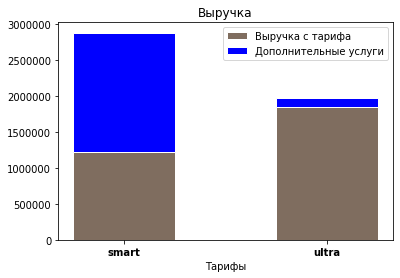

In [110]:
df_users_monthly['additional']= df_users_monthly['revenue'] - df_users_monthly['rub_monthly_fee']
additional_ultra=df_users_monthly[df_users_monthly['tariff_name']=='ultra']['additional'].sum()
#print('Доля дополнительной выручки для тарифа Ультра в общей выручке от тарифа', additional_ultra/ultra_rev.sum())
additional_smart=df_users_monthly[df_users_monthly['tariff_name']=='smart']['additional'].sum()
#print('Доля дополнительной выручки для тарифа Смарт в общей выручке от тарифа', additional_smart/smart_rev.sum())

revenue_ultra=df_users_monthly[df_users_monthly['tariff_name']=='ultra']['revenue'].sum()
revenue_smart=df_users_monthly[df_users_monthly['tariff_name']=='smart']['revenue'].sum()
print('TOTAL выручка в тарифе Смарт с 500 абоненов в выборке', revenue_smart)
print('Средняя выручка с абонента тарифа Смарт', round(smart_rev.mean()))
print('TOTAL выручка в тарифе Ультра с 500 абоненов в выборке', revenue_ultra)
print('Средняя выручка с абонента тарифа Ультпа', round(ultra_rev.mean()))

#print('Доп выручка тарифа Смарт с 500 абоненов в выборке', additional_smart)
#print('Доп выручка тарифа Ультра с 500 абоненов в выборке', additional_ultra)

normal_revenue=[revenue_smart-additional_smart,revenue_ultra-additional_ultra]
additional_revenue=[additional_smart,additional_ultra]
plt.bar([0,1], normal_revenue, color='#7f6d5f', edgecolor='white', width=0.5, label='Выручка с тарифа');
plt.bar([0,1], additional_revenue, bottom= normal_revenue, color='blue', edgecolor='white', width=0.5, label='Дополнительные услуги')
plt.xticks([0,1], ['smart','ultra'], fontweight='bold')
plt.xlabel("Тарифы")
plt.title("Выручка")
plt.legend();

## Общие выводы <a class="anchor" id="6"></a>

<li> Мы сравнили выручки по тарифам "Смарт" и "Ультра" и отвергли гипотезу об их равенстве. 
<li> Также мы сравнили выручки в Москве и в регионах, и не смогли отвергнуть гипотезу об их равенстве на основе данной выборки. Однако это все же не доказывает, что выручки равны. Для ответа на этот вопрос необходимы исследования на дополнительных более широких сэмплах.
<li> Абонентов тарифа Ультра значительно меньше, как в Москве, так и в регионах, однако суммарная выручка в данной выборке по тарифу Ультра составила почти 40% от общей выручки за счет более дорогой стоимости тарифа.
<li> В то же время мы увидели, что большая часть абонентов в тарифе Ультра не использует все минуты и сообщения. Это может привести к переключению абонентов на более дешевые тарифы( например, где есть пакет интернета, но не надо платить на ненужные минуты)
<li> В тарифе Смарт почти половину выручки вероятно составляют дополнительные услуги. 
<li> С точки зрения роста есть Смысл развивать тариф Смарт, добавляя в него дополнительные опции по пакетам интернета.
<li> <b> Общая выручка с тарифа Смарт с учетом дополнительных услуг выше за счет популярности тарифа (и его базовой доступности), поэтому имеет смысл рекламировать тариф Смарт.
